<a href="https://colab.research.google.com/github/mmaruthi/Deep_Learning_EVA4_Phase1/blob/master/S12_TinyImageNet_ResNet/K-Means%2BAnchorBox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anchor Boxes - YOLO V2 

Steps:
1. Get each Bounding box - Compute Center , Width, Height and normalize it by image dimensions 

2. Plot the h and w for each box as shown in the right "h vs w graph"

3. Use K-means clustering to compute cluster centers (centroids).

4. Compute the different numbers of clusters and compute the mean of maximum IOU between bounding boxes and individual anchors.

5. Plot centroids vs mean IOU.

6. Pick the top 5 anchor boxes (5 for YOLOv2 where IOU was above 65%)

In [1]:
!git clone https://github.com/mmaruthi/EVA4-Data

fatal: destination path 'EVA4-Data' already exists and is not an empty directory.


In [0]:
from tqdm.notebook import tqdm, trange
path = '/content/EVA4-Data/Dogs/'
import os
from skimage import io
sizedict = {}
for filename in os.listdir(path):
  image = io.imread(f'{path}{filename}', as_gray=False, pilmode="RGB")
  sizedict[filename] = image.shape[:2]

In [0]:
import json
annot = json.load(open('/content/EVA4-Data/Dogs_annotations.json'))

# Data Clustering #

In [5]:
import numpy as np 
import pandas as pd 
import math
df = pd.DataFrame()

data = []
for k, v in annot.items():
  for r in v['regions']:
    d = {'name': v['filename'] }
    s = r['shape_attributes']
    h, w = sizedict[v['filename']]
    d['h'] = s['height']
    d['w'] = s['width']
    d['x'] = s['x']
    d['y'] = s['y']
    d['image_w'] = w
    d['image_h'] = h
    d['height'] = s['height']/h
    d['width'] = s['width']/w
    d['log_height'] = math.log(s['height']/h)
    d['log_width'] = math.log(s['width']/h)

    data.append(d)


df = pd.DataFrame.from_dict(data, orient='columns')
df.head()

,name,h,w,x,y,image_w,image_h,height,width,log_height,log_width
0,Dog1.jpg,482,349,203,20,800,572,0.842657,0.436250,-0.171195,-0.494067
1,Dog2.jpg,834,551,56,5,636,900,0.926667,0.866352,-0.076161,-0.490660
2,Dog3.jpg,515,631,115,5,800,530,0.971698,0.788750,-0.028710,0.174429
3,Dog4.jpg,799,438,166,35,644,900,0.887778,0.680124,-0.119034,-0.720176
4,Dog5.jpg,430,362,202,379,636,900,0.477778,0.569182,-0.738610,-0.910751


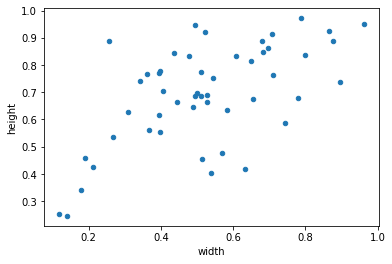

In [6]:
df.plot.scatter('width', 'height')


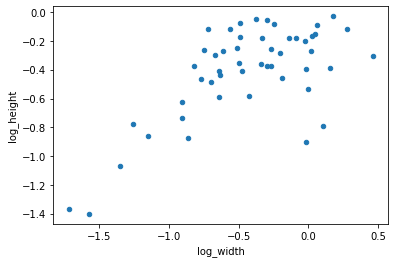

In [7]:
df.plot.scatter('log_width', 'log_height')



K Means clustering
Using Scikit learn's K Means with k from 1 to 20

In [0]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt


Get the X by using log of width and height

In [0]:

X = df[['log_width', 'log_height']].to_numpy()


IOU Calculation
Below method will find the best centroid for a given bounding box

In [0]:
# given centroids find the maximum IOU of a bbox
def iou(box, centroids):
    x = np.minimum(np.exp(centroids[:, 0]), np.exp(box[0]))
    y = np.minimum(np.exp(centroids[:, 1]), np.exp(box[1]))

    intersection = x * y
    box_area = np.exp(box[0]) * np.exp(box[1])
    centroid_area = np.exp(centroids[:, 0]) * np.exp(centroids[:, 1])

    iou_ = intersection / (box_area + centroid_area - intersection)
    #return iou_
    return (np.max(iou_), np.argmax(iou_))


Execute K Means
Now let us run our kmeans. We will calculate for each value of k

distortions
inertias
cluster memberships
cluster centroids
mean of maximum IOU between bounding boxes and individual anchors

In [0]:

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
centroids = {}
memberships = {}
miou = []
K = range(1, 21)

for k in K:
  kmeansModel = KMeans(n_clusters=k).fit(X)
  distortions.append(sum(np.min(cdist(X, kmeansModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
  inertias.append(kmeansModel.inertia_) 

  mapping1[k] = sum(np.min(cdist(X, kmeansModel.cluster_centers_, 
                'euclidean'),axis=1)) / X.shape[0] 
  mapping2[k] = kmeansModel.inertia_ 
  centroids[k] = kmeansModel.cluster_centers_
  maxiou = np.array([iou(b, centroids[k])  for b in X])
  memberships[k] = maxiou[:, 1].astype(np.uint8)
  # find mean of maximum IOU between bounding boxes and individual anchors
  miou.append(np.mean(maxiou[:, 0]))

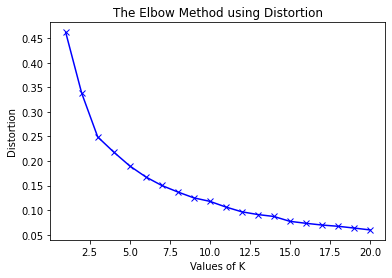

In [15]:

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

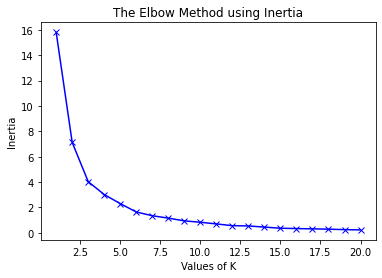

In [16]:

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

Plot centroid vs mean IOU

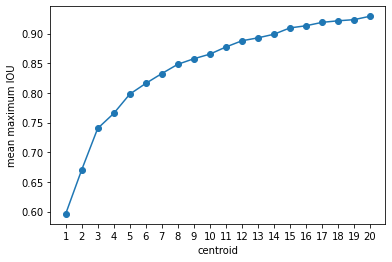

In [17]:

def plotIOU(X, Y):
  plt.scatter(X, Y)
  plt.plot(X, Y)
  plt.xlabel("centroid")
  plt.ylabel("mean maximum IOU")
  plt.xticks(np.arange(1, 21))
  plt.show()

plotIOU(K, miou)

While from both of above plots K=3 seems to be doing OK, but 5 is also not a bad choice. Becase after 5, mostly it is liner with a flat slope. Let us do k = 3 to 6 and visualize

Cluster Plots

In [18]:
import seaborn as sns
def plotclusters(k):
  #ax = df.plot.scatter('log_width', 'log_height', c=f'cluster{k}', colormap='viridis')
  ax = sns.scatterplot('log_width', 'log_height', data=df, hue=memberships[k], style = memberships[k], palette="Set2")
  ax.scatter(centroids[k][:,0], centroids[k][:,1], marker='*', c='black')
  plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


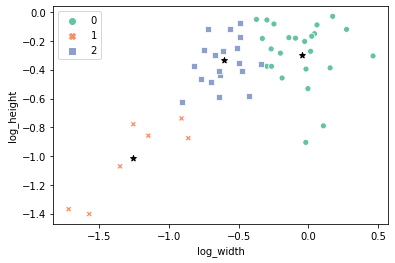

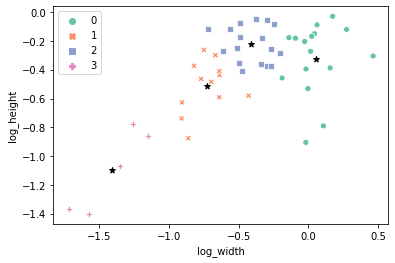

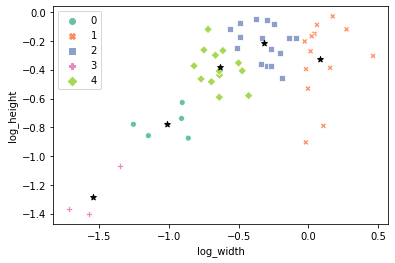

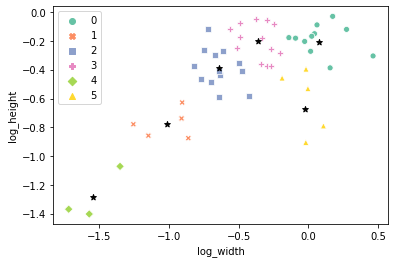

In [19]:

for k in [3, 4, 5, 6]:
  plotclusters(k)


Customized K Means
While above works well, however while we are using membership based upon max IOU, we are using other default distance metric to find which cluster is close to a point in K means. That is because scikit learn's k means does not allow us to provision our own distance metric.

In [20]:

!pip install pyclustering

     |████████████████████████████████| 2.6MB 2.8MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.9.3.1-cp36-none-any.whl size=2599356 sha256=b2df4033bea0bc70e8cdebc5b7277700dd5e60573d126c1f3cec898bdd65d0b5
  Stored in directory: /root/.cache/pip/wheels/34/d6/ac/59746c226a35752edcd786d3ab96f9b547a2b70d0fbda92015
Successfully built pyclustering



IOU based Distance Metric
IOU is a number between 0 and 1. The larger the better. So distance for k means should be 1 - IOU. We will use another package to achieve that.

In [0]:
# given centroids find the maximum IOU of a bbox
def ioudist(box, centroid):
    #print(centroid)
    x = np.minimum(np.exp(centroid[0]), np.exp(box[0]))
    y = np.minimum(np.exp(centroid[1]), np.exp(box[1]))

    intersection = x * y
    box_area = np.exp(box[0]) * np.exp(box[1])
    centroid_area = np.exp(centroid[0]) * np.exp(centroid[1])

    iou_ = intersection / (box_area + centroid_area - intersection)
    return 1 - iou_

Clustering K MEANS
Again we shall store the memberships, mean max IOU for each centroid etc. as before

In [0]:
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import type_metric, distance_metric

metric = distance_metric(type_metric.USER_DEFINED, func=ioudist)
clusters = []
final_centers = []
mean_iou = []
for k in K:
  # Prepare initial centers using K-Means++ method.
  initial_centers = kmeans_plusplus_initializer(X, k).initialize()

  if k==1:
    kmeans_instance = kmeans(X, initial_centers)  
  else:
    kmeans_instance = kmeans(X, initial_centers, metric=metric)

  kmeans_instance.process()
  clusters.append(kmeans_instance.get_clusters())
  c = np.array(kmeans_instance.get_centers())
  final_centers.append(c)
  maxiou = np.array([iou(b, c)  for b in X])
  mean_iou.append(np.mean(maxiou[:, 0]))

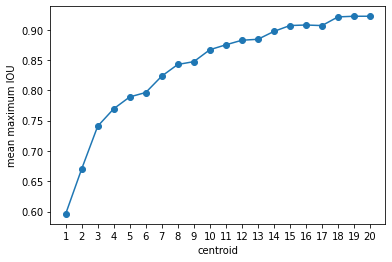

In [23]:
plotIOU(K, mean_iou)

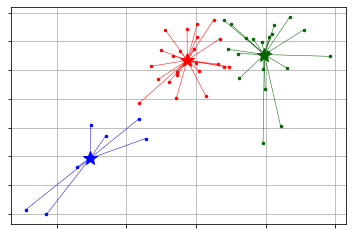

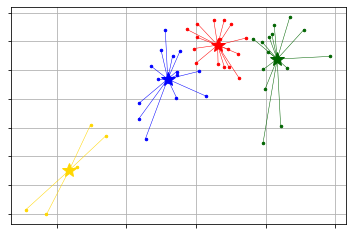

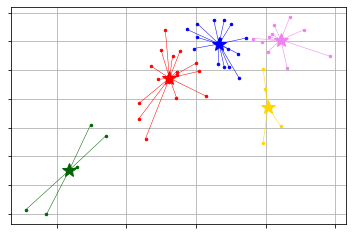

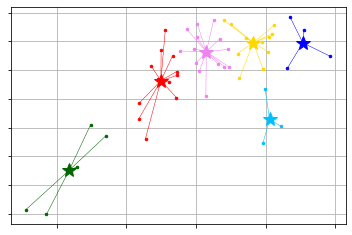

In [24]:

for k in range(2, 6):
  kmeans_visualizer.show_clusters(X, clusters[k], final_centers[k])

PLOT Top 3 Anchor boxes where IOU > 75%

In [0]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

def make_anchor_boxes(ax, clusters, facecolor='None', edgecolor='b', alpha=1):

    xdata = np.array([0.5]*len(clusters))
    ydata = np.array([0.5]*len(clusters))

    xerror = np.array([list(np.exp(clusters[:, 0])/2)]*2)
    yerror = np.array([list(np.exp(clusters[:, 1])/2)]*2)
    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
        rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to axes
    ax.add_collection(pc)

    # Plot errorbars
    artists = ax.errorbar(xdata, ydata, xerr=xerror, yerr=yerror,
                          fmt='None', ecolor='None')

    return artists

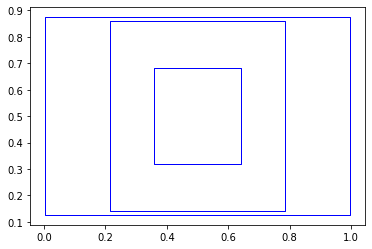

In [26]:
# Create figure and axes
fig, ax = plt.subplots(1)

# Call function to create error boxes
_ = make_anchor_boxes(ax, final_centers[2])

plt.show()

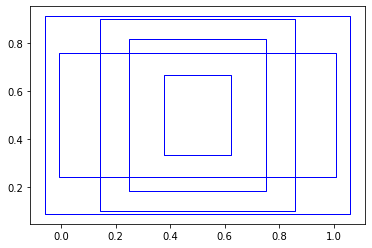

In [27]:

# Create figure and axes
fig, ax = plt.subplots(1)

# Call function to create error boxes
_ = make_anchor_boxes(ax, final_centers[4])

plt.show()